<a href="https://colab.research.google.com/github/Leomutz/NIDS1/blob/main/SACAIR2024_tutorial03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What are Pulsars?

* Pulsars are created when supermassive stars with mass between 10-20 M$_{\odot}$ (1 M$_{\odot}$$\sim2\times10^{30}$ kg) collapse under their own gravity.
* These are violent explosions and the outer layers of the supermassive star a repelled into space leaving behind a dense core that is $\sim$ 10 km in diameter.
* This dense core is known as a pulsar.
* And because of the conservation of angular momentum and magnetic flux these pulsars spin **VERY FAST** (1000 times per second) and they have **enormous** magnetic fields (trillion times stronger than that of Earth).
* This beautiful combination of **spinnig very fast and high magnetic fields** give pulsar their unique characteristic: they produce pulsed emision from their poles!

# Pretty picture of a Pulsar [Sadly, not real :( ]

In [1]:
from IPython.display import Image, display

# Display an image from the local directory
display(Image(url='https://cdn.mos.cms.futurecdn.net/bXYyJ7KyHaJVTmEhvm4Din.jpg.webp', height=1000, width=900))

# Lighthouse Effect

In [2]:
display(Image(url='https://upload.wikimedia.org/wikipedia/commons/4/4d/Lightsmall-optimised.gif'))

# The Use of AI in Astrophysics

* As telescopes observe the night sky, they gather a huge amount of data ($\sim$ terabytes) trying to discover new pulsars.
* This data must then be reduced to identify pulsar from non-pulsar data.
* This becomes a very **TEDIOUS** task for mere mortals.
* This is where AI comes in and saves the day.
* Using deep learning and neural networks, astronomers can train models to look for pulsar feautures in these vast amount of data that is collected daily.
* So that is what we are going to do today. We'll generate some synthetic pulsar and non-pulsar (noise) data and see if the model can identify and seperate the two data sets.

 Importing necessary libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd

### Function to simulate a pulsar signal (sine wave)

In [4]:
def generate_pulsar_signal(length=100, frequency=0.1, amplitude=1):
    t = np.linspace(0, length, length)
    return amplitude * np.sin(2 * np.pi * frequency * t)

### Function to simulate non-pulsar signal (random noise)

In [5]:
def generate_non_pulsar_signal(length=100):
    return np.random.normal(0, 1, length)

Simulating a dataset of pulsar and non-pulsar signals

In [6]:
num_samples = 1000
signal_length = 100

Generate pulsar-like signals (periodic signals)

In [7]:
pulsar_signals = np.array([generate_pulsar_signal(length=signal_length) for _ in range(num_samples // 2)])

Generate non-pulsar-like signals (random noise)

In [8]:
non_pulsar_signals = np.array([generate_non_pulsar_signal(length=signal_length) for _ in range(num_samples // 2)])

### Label the data: 1 for pulsar, 0 for non-pulsar

In [9]:
labels_pulsar = np.ones(num_samples // 2)
labels_non_pulsar = np.zeros(num_samples // 2)

Combine the signals and labels into a single dataset

In [10]:
signals = np.vstack([pulsar_signals, non_pulsar_signals])
labels = np.hstack([labels_pulsar, labels_non_pulsar])


Shuffle the dataset

In [11]:
indices = np.random.permutation(len(signals))
signals = signals[indices]
labels = labels[indices]

Feature extraction function

In [12]:
def extract_features(signals):
    '''Calculates the statistics of the data for the model to use'''
    features = []
    for signal in signals:
        mean = np.mean(signal)
        variance = np.var(signal)
        peak_to_peak = np.ptp(signal)  # Peak-to-peak value
        features.append([mean, variance, peak_to_peak])
    return np.array(features)

Extract features from the signals

In [13]:
features = extract_features(signals)

### Split the dataset into training and testing sets

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                                    test_size=0.3, random_state=42)

## Random Forest Classifier
This is an ensemble technique that combines multiple decision trees in order to improve the classification accuracy and control overfitting to the training data.


In [15]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#train the model
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Predicting on the test set

In [16]:
y_pred = rf_model.predict(X_test)

Evaluating the performance

In [17]:
print("Random Forest Classifier Performance:")
print(classification_report(y_test, y_pred))
# print(confusion_matrix(y_test, y_pred))

Random Forest Classifier Performance:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       158
         1.0       1.00      1.00      1.00       142

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



Plot confusion matrix

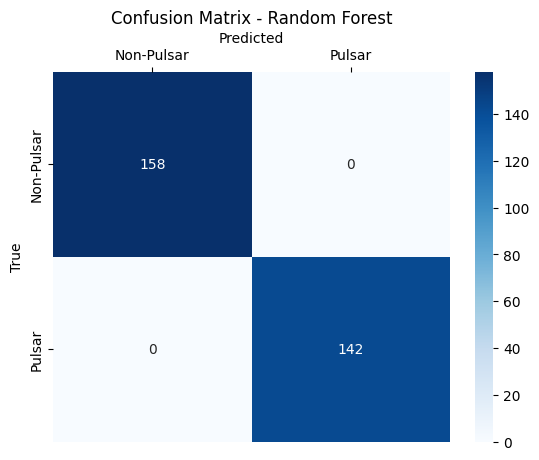

In [18]:
import seaborn as sns
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Pulsar', 'Pulsar'], yticklabels=['Non-Pulsar', 'Pulsar'])
plt.title('Confusion Matrix - Random Forest')
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Predicted')
plt.gca().xaxis.tick_top()
plt.ylabel('True')
plt.show()

### Building a simple neural network for classification

In [19]:
model = Sequential() # linear stack of layers for building a NN
model.add(Dense(64, input_dim=3, activation='relu'))  # First hidden layer with 64 neurons
model.add(Dropout(0.5))  # Dropout to prevent overfitting
model.add(Dense(32, activation='relu'))  # Second hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (sigmoid for binary classification)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compile the model

In [20]:
#Adam() optimizer is used for its adaptive learning rate properties
# Configure the model for training
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

Train the model

In [21]:
# Goes through the entire data set 20 times
history = model.fit(X_train, y_train,
                    epochs=20, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4950 - loss: 0.8131 - val_accuracy: 0.5267 - val_loss: 0.6148
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4929 - loss: 0.6392 - val_accuracy: 0.5267 - val_loss: 0.5744
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4976 - loss: 0.6194 - val_accuracy: 0.5267 - val_loss: 0.5428
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5592 - loss: 0.5677 - val_accuracy: 0.5267 - val_loss: 0.5037
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6171 - loss: 0.5346 - val_accuracy: 1.0000 - val_loss: 0.4410
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7637 - loss: 0.4784 - val_accuracy: 1.0000 - val_loss: 0.3668
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9134 - loss: 0.4251 - val_accuracy: 1.0000 - val_loss: 0.2827
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9552 - loss: 0.3425 - val_accuracy: 1.0000 - val_loss

Evaluate the model

In [22]:
print("Deep Learning Model Performance:")
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

Deep Learning Model Performance:
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0073 
Loss: 0.0075, Accuracy: 1.0000


### Plot training and validation accuracy over epochs

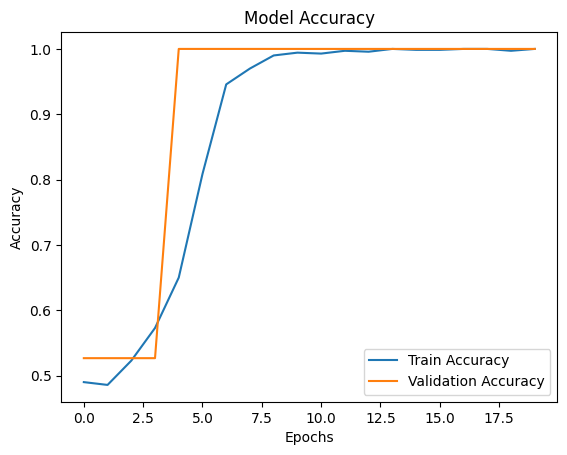

In [23]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Plotting some example pulsar and non-pulsar signals

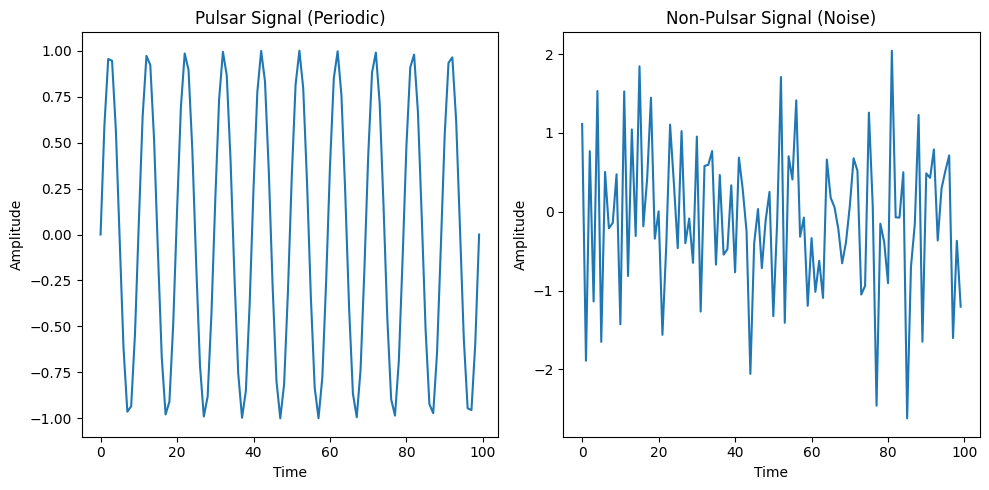

In [24]:
plt.figure(figsize=(10, 5))

# Plot a pulsar signal
plt.subplot(1, 2, 1)
plt.plot(pulsar_signals[3])
plt.title('Pulsar Signal (Periodic)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

# Plot a non-pulsar signal (random noise)
plt.subplot(1, 2, 2)
plt.plot(non_pulsar_signals[3])
plt.title('Non-Pulsar Signal (Noise)')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [ ]:
pwd

'/home/ensci/Desktop/Lurgasho/FERMI_EUVE/Final_Analysis2/05_Nov_05_10GeV'